# Business Context

This case requires trainees to develop a model for predicting fraudulent transactions for a
financial company and use insights from the model to develop an actionable plan. Data for the
case is available in CSV format having 6362620 rows and 10 columns.

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [4]:
import pandas as pd

# Load with dtype optimization (strings → category, floats kept as float32 to save memory)

dtypes = {
    'step': 'int16',
    'type': 'category',
    'amount': 'float32',
    'nameOrig': 'category',
    'oldbalanceOrg': 'float32',
    'newbalanceOrig': 'float32',
    'nameDest': 'category',
    'oldbalanceDest': 'float32',
    'newbalanceDest': 'float32',
    'isFraud': 'int8',
    'isFlaggedFraud': 'int8'
}

In [6]:
df1=pd.read_csv(r"Pandas/Fraud.csv") 

In [54]:
df1

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


In [55]:
df1.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 1.4 GB


In [56]:
df1['type'].value_counts()

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

# Step 1- Data Cleaning & Preprocessing

# 1A: Missing values check

In [57]:
df1.isnull().sum() #Checking missing values

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [58]:
df1.duplicated().sum()  #checking are there any duplicates 

0

# 1B: Outlier detection
Identifying data points that deviate significantly from the rest of the dataset. 
These points are unusually too high, too low, or inconsistent compared to the normal pattern.

In [7]:
df1[['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']].describe(percentiles=[0.99,0.999])

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06
std,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05
99%,1.615979e+06,1.602726e+07,1.617616e+07,1.237182e+07,1.313787e+07
99.9%,8.956798e+06,2.682593e+07,2.697166e+07,3.439279e+07,3.953157e+07
max,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08


In [11]:
# Standard deviation std is very high compared to the mean, which indicates values vary widely. 
# This usually suggests heavy-tailed distributions where most are small but a few are huge.

# 50% (Median), This means half the transactions are less than 7.487194e+04	.
# Mean, But the mean is much higher (1.798619e+05), meaning the distribution is skewed by very large transactions.
# Max, Maximum transaction amount is ~924 million. Maximum balances (oldbalanceDest, newbalanceDest) are even higher (~356 million).
# These are huge compared to the median, showing extreme outliers that could represent laundering or fraud attempts.

In [8]:
df2=df1.copy()

In [9]:
df2['errorBalanceOrig'] = df2['newbalanceOrig'] + df2['amount'] - df2['oldbalanceOrg']
df2['errorBalanceDest'] = df2['oldbalanceDest'] + df2['amount'] - df2['newbalanceDest']

In [10]:
df2

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,errorBalanceOrig,errorBalanceDest
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0,0.0,9.839640e+03
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0,0.0,1.864280e+03
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,0.0,1.810000e+02
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0,0.0,2.136300e+04
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0,0.0,1.166814e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0,0.0,0.000000e+00
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0,0.0,6.311409e+06
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0,0.0,1.000000e-02
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0,0.0,8.500025e+05


In [11]:
df2['amount'].skew() #checking skewness

30.99394948249038

In [12]:
(df2['newbalanceOrig'] < 0).sum()       #Check if balances ever go negative after transactions:
(df2['newbalanceDest'] < 0).sum()

0

In [13]:
Q1, Q3 = df2['amount'].quantile([0.25, 0.75])

# Calculate IQR
IQR = Q3 - Q1

print(f"Q1 (25th percentile): {Q1}")
print(f"Q3 (75th percentile): {Q3}")
print(f"IQR: {IQR}")

Q1 (25th percentile): 13389.57
Q3 (75th percentile): 208721.4775
IQR: 195331.9075


In [34]:
# The central 50% of amount is between 13389.57 and 208721.4775, a spread of 195331.9075.

In [14]:
# Calculate the Lower and Upper Fences
lower_fence = Q1 - 1.5 * IQR
upper_fence = Q3 + 1.5 * IQR

print(f"Lower Fence: {lower_fence}")
print(f"Upper Fence: {upper_fence}")

Lower Fence: -279608.29125
Upper Fence: 501719.33875


In [31]:
Any value below -279608.29125 or above 501719.33875 will be considered an outlier.

In [15]:
# Find outliers (values below the lower fence OR above the upper fence)
outliers = df2[(df2['amount'] < lower_fence) | (df2['amount'] > upper_fence)]

print("\nOutliers found:")
outliers


Outliers found:


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,errorBalanceOrig,errorBalanceDest
85,1,TRANSFER,1505626.01,C926859124,0.00,0.0,C665576141,29031.00,5515763.34,0,0,1505626.01,-3.981106e+06
86,1,TRANSFER,554026.99,C1603696865,0.00,0.0,C766572210,579285.56,0.00,0,0,554026.99,1.133313e+06
88,1,TRANSFER,761507.39,C412788346,0.00,0.0,C1590550415,1280036.23,19169204.93,0,0,761507.39,-1.712766e+07
89,1,TRANSFER,1429051.47,C1520267010,0.00,0.0,C1590550415,2041543.62,19169204.93,0,0,1429051.47,-1.569861e+07
93,1,TRANSFER,583848.46,C1839168128,0.00,0.0,C1286084959,667778.00,2107778.11,0,0,583848.46,-8.561516e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362613,743,CASH_OUT,1258818.82,C1436118706,1258818.82,0.0,C1240760502,503464.50,1762283.33,1,0,0.00,-1.000000e-02
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0,0.00,6.311409e+06
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0,0.00,1.000000e-02
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0,0.00,8.500025e+05


In [21]:
df2['is_amount_outlier'] = (df2['amount'] < lower_fence) | (df2['amount'] > upper_fence)   # for checking 

In [ ]:
outliers.sum()    # Don't run this command this will take a whole weak

In [18]:
df2['amount_capped'] = df2['amount'].clip(upper=df2['amount'].quantile(0.999))  # winsorize the 0.1% of highest transactions large values 

In [23]:
df2['amount_log'] = np.log1p(df2['amount'])  # log1p handles log(0) safely, to reduce skew and shrink outlier influence

In [24]:
df2

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,errorBalanceOrig,errorBalanceDest,is_amount_outlier,amount_capped,amount_log
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0,0.0,9.839640e+03,False,9839.64,9.194276
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0,0.0,1.864280e+03,False,1864.28,7.531166
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,0.0,1.810000e+02,False,181.00,5.204007
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0,0.0,2.136300e+04,False,181.00,5.204007
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0,0.0,1.166814e+04,False,11668.14,9.364703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0,0.0,0.000000e+00,False,339682.13,12.735768
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0,0.0,6.311409e+06,True,6311409.28,15.657870
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0,0.0,1.000000e-02,True,6311409.28,15.657870
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0,0.0,8.500025e+05,True,850002.52,13.652996


In [ ]:
# ===============================  Quick check  ===============================  #

In [26]:
print("Original skewness:", df2['amount'].skew())
print("Capped skewness  :", df2['amount_capped'].skew())
print("Log skewness     :", df2['amount_log'].skew())

print("\nSample rows:")
print(df2[['amount', 'is_amount_outlier', 'amount_capped', 'amount_log']].head(10))

Original skewness: 30.99394948249038
Capped skewness  : 12.08172317722513
Log skewness     : -0.5550183204227738

Sample rows:
     amount  is_amount_outlier  amount_capped  amount_log
0   9839.64              False        9839.64    9.194276
1   1864.28              False        1864.28    7.531166
2    181.00              False         181.00    5.204007
3    181.00              False         181.00    5.204007
4  11668.14              False       11668.14    9.364703
5   7817.71              False        7817.71    8.964275
6   7107.77              False        7107.77    8.869085
7   7861.64              False        7861.64    8.969878
8   4024.36              False        4024.36    8.300370
9   5337.77              False        5337.77    8.582751


# 1C: Multi-collinearity
Multicollinearity occurs when two or more independent (predictor) variables in a dataset are highly correlated with each other. 
This means one variable can be linearly predicted from another with a high degree of accuracy.

In [30]:
corr = df2[['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest',
           'errorBalanceOrig','errorBalanceDest']].corr()

In [23]:
#correaltion matrix

In [31]:
corr     

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,errorBalanceOrig,errorBalanceDest
amount,1.000000,-0.002762,-0.007861,0.294137,0.459304,0.970660,-0.189928
oldbalanceOrg,-0.002762,1.000000,0.998803,0.066243,0.042029,0.050502,0.156464
newbalanceOrig,-0.007861,0.998803,1.000000,0.067812,0.041837,0.056897,0.163161
oldbalanceDest,0.294137,0.066243,0.067812,1.000000,0.976569,0.304256,-0.025460
newbalanceDest,0.459304,0.042029,0.041837,0.976569,1.000000,0.458750,-0.174942
errorBalanceOrig,0.970660,0.050502,0.056897,0.304256,0.458750,1.000000,-0.147540
errorBalanceDest,-0.189928,0.156464,0.163161,-0.025460,-0.174942,-0.147540,1.000000


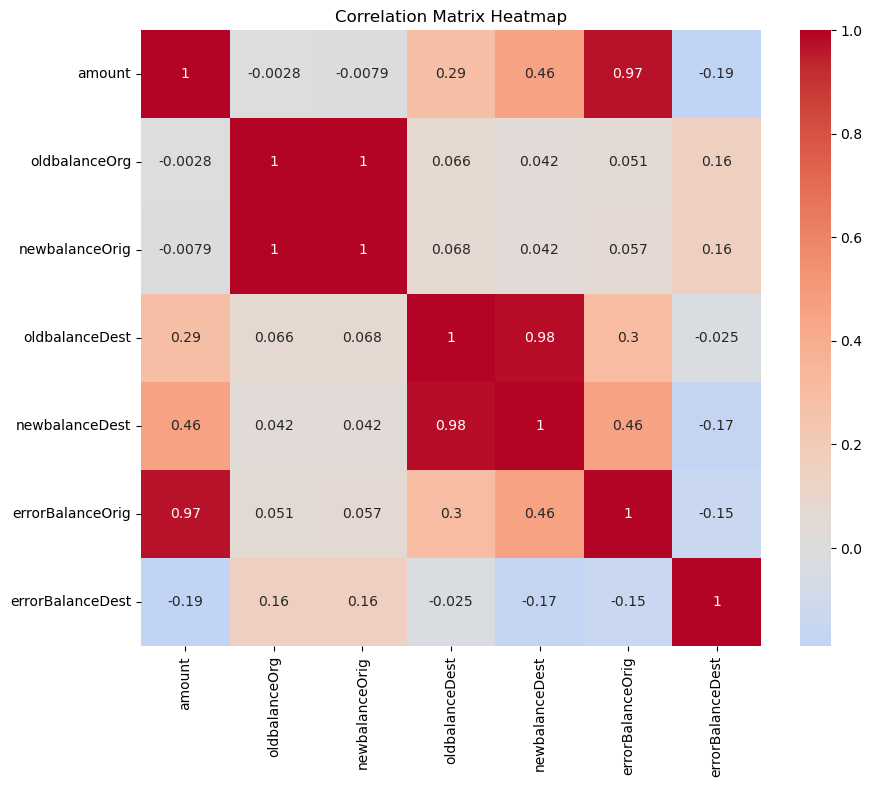

In [32]:
# Visualize it with a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix Heatmap')
plt.show()

| Feature Pair                        | Correlation | Interpretation                                                                                                            |
| ----------------------------------- | ----------- | ------------------------------------------------------------------------------------------------------------------------- |
| `amount` & `errorBalanceOrig`       | 0.97        | Very strong positive correlation. This makes sense, because `errorBalanceOrig = newbalanceOrig + amount - oldbalanceOrg`. |
| `oldbalanceOrg` & `newbalanceOrig`  | 0.9988      | Extremely high correlation. Essentially redundant — one can almost predict the other.                                     |
| `oldbalanceDest` & `newbalanceDest` | 0.9766      | Very strong correlation — likely redundant as well.                                                                       |
| `amount` & `newbalanceDest`         | 0.4593      | Moderate positive correlation.                                                                                            |
| `amount` & `oldbalanceDest`         | 0.2941      | Low to moderate correlation.                                                                                              |
| Other correlations                  | mostly low  | Not a major concern.                                                                                                      |


🔹 Conclusion

High multicollinearity exists between: oldbalanceOrg ↔ newbalanceOrig | oldbalanceDest ↔ newbalanceDest | amount ↔ errorBalanceOrig

Features with correlation > 0.95 are essentially redundant.

🔹 Suggested actions

For linear/logistic regression: Keep one of each highly correlated pair, Keep either oldbalanceOrg or newbalanceOrig, Keep either oldbalanceDest or newbalanceDest

For tree-based models: You can keep both, but you may still want to remove obvious redundancy to reduce complexity.

In [33]:
df2

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,errorBalanceOrig,errorBalanceDest,is_amount_outlier,amount_capped,amount_log
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0,0.0,9.839640e+03,False,9839.64,9.194276
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0,0.0,1.864280e+03,False,1864.28,7.531166
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,0.0,1.810000e+02,False,181.00,5.204007
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0,0.0,2.136300e+04,False,181.00,5.204007
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0,0.0,1.166814e+04,False,11668.14,9.364703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0,0.0,0.000000e+00,False,339682.13,12.735768
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0,0.0,6.311409e+06,True,6311409.28,15.657870
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0,0.0,1.000000e-02,True,6311409.28,15.657870
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0,0.0,8.500025e+05,True,850002.52,13.652996


# VIF FOR LINEAR MODELS ONLY

(VIF) is a statistical measure used to detect multicollinearity among independent (predictor) variables in a regression model. It quantifies how much the variance (uncertainty) of a regression coefficient is inflated due to multicollinearity.

VIF = 1: No correlation between this feature and others.

1 < VIF < 5: Moderate correlation. Usually acceptable.

5 <= VIF < 10: High correlation. Cause for concern.

VIF >= 10: Severe multicollinearity. This feature needs to be addressed. 

In [13]:
features_for_vif = ['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest',
                    'errorBalanceOrig','errorBalanceDest']

In [ ]:
vif_df = df2[features_for_vif].dropna().copy() 
# To prepare a clean subset of data,
# containing only the features you want to analyze for multicollinearity.

vif_df = vif_df.assign(const=1.0)
# Vif requires a constant term,Without this, the VIF calculation might raise an error.
# similar to adding an intercept column (bias term) in linear regression.

vif = pd.DataFrame({
    'feature': features_for_vif,
    'VIF': [variance_inflation_factor(vif_df.values, i) for i in range(len(features_for_vif))]
})
# To create a summary table showing each feature and its Variance Inflation Factor.

In [15]:
vif

,feature,VIF
0,amount,1.391370e+10
1,oldbalanceOrg,2.955836e+09
2,newbalanceOrig,1.813737e+11
3,oldbalanceDest,4.370008e+08
4,newbalanceDest,1.541592e+08
5,errorBalanceOrig,2.395146e+07
6,errorBalanceDest,1.051990e+09


In [34]:
df2

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,errorBalanceOrig,errorBalanceDest,is_amount_outlier,amount_capped,amount_log
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0,0.0,9.839640e+03,False,9839.64,9.194276
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0,0.0,1.864280e+03,False,1864.28,7.531166
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,0.0,1.810000e+02,False,181.00,5.204007
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0,0.0,2.136300e+04,False,181.00,5.204007
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0,0.0,1.166814e+04,False,11668.14,9.364703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0,0.0,0.000000e+00,False,339682.13,12.735768
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0,0.0,6.311409e+06,True,6311409.28,15.657870
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0,0.0,1.000000e-02,True,6311409.28,15.657870
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0,0.0,8.500025e+05,True,850002.52,13.652996


In [17]:
# Select only numeric columns (after creating errorBalanceOrig & errorBalanceDest)
numeric_features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 
                    'oldbalanceDest', 'newbalanceDest', 
                    'errorBalanceOrig', 'errorBalanceDest']

X = df2[numeric_features]

# Function to calculate VIF
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]
    return vif_data

print(" Initial VIF values:")
print(calculate_vif(X))

# Drop redundant columns
df2 = df2.drop(columns=['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest',
                        'nameOrig', 'nameDest', 'isFlaggedFraud'])

# Recompute VIF on reduced set, check multicollinearity after removing problematic variables.
X_reduced = df2[['amount', 'errorBalanceOrig', 'errorBalanceDest']]
print("\n VIF after dropping redundant features:")
print(calculate_vif(X_reduced))


🔹 Initial VIF values:
            feature           VIF
0            amount  1.297867e+12
1     oldbalanceOrg  2.906955e+10
2    newbalanceOrig  1.297669e+10
3    oldbalanceDest  9.866397e+08
4    newbalanceDest  3.736216e+09
5  errorBalanceOrig  6.196113e+07
6  errorBalanceDest  4.533059e+08

🔹 VIF after dropping redundant features:
            feature        VIF
0            amount  19.510850
1  errorBalanceOrig  19.292507
2  errorBalanceDest   1.055893


In [ ]:
# output:

"""A VIF above 10 indicates multicollinearity is still high.

Here amount and errorBalanceOrig are still strongly correlated 
(which makes sense mathematically, since errorBalanceOrig was derived from amount).

errorBalanceDest is fine (≈ 1)."""

# Final cleaned dataframe 

In [78]:
df2       #final cleaned dataframe 

,step,type,amount,isFraud,errorBalanceOrig,errorBalanceDest
0,1,PAYMENT,9839.64,0,0.0,9.839640e+03
1,1,PAYMENT,1864.28,0,0.0,1.864280e+03
2,1,TRANSFER,181.00,1,0.0,1.810000e+02
3,1,CASH_OUT,181.00,1,0.0,2.136300e+04
4,1,PAYMENT,11668.14,0,0.0,1.166814e+04
...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,1,0.0,0.000000e+00
6362616,743,TRANSFER,6311409.28,1,0.0,6.311409e+06
6362617,743,CASH_OUT,6311409.28,1,0.0,1.000000e-02
6362618,743,TRANSFER,850002.52,1,0.0,8.500025e+05


# For fraud detection, not every column in the raw dataset is equally useful. Here’s the reasoning:

step → important, because it captures time (transactions over days/hours). Fraud often has temporal patterns.

type → critical, because fraud occurs more in CASH-OUT and TRANSFER, but rarely in PAYMENT.

amount → essential, because fraud amounts are usually higher or abnormal.

errorBalanceOrig → engineered feature that captures whether money was debited properly from the source. Strong fraud signal.

errorBalanceDest → engineered feature that captures mismatch in credited balance. Also strong fraud signal.

isFraud →  target label for training.

# other columns:

nameOrig / nameDest → purely identifiers (categorical with huge unique values, not meaningful), so they add noise.

isFlaggedFraud → almost 0 in the dataset and not used in labeling. Drop it.

oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest → redundant after you create errorBalanceOrig and errorBalanceDest. Drop them.

# Step 2- Describe your fraud detection model in elaboration.
To detect fraudulent transactions, two models were developed. Logistic Regression served as a baseline due to its interpretability, while a Random Forest classifier was employed for stronger predictive performance (Although it didn't wrok properly due to large amount of data). Since fraud cases are highly imbalanced in the dataset, the SMOTE technique was applied to oversample minority cases, ensuring balanced training. Features selected included transaction amount (log-transformed and capped), error balance features, and transaction type dummies.

The Logistic Regression model highlighted that inconsistencies in balances (errorBalanceOrig, errorBalanceDest) and large transaction amounts were the most significant predictors of fraud. However, its predictive power was limited due to the complexity of fraud patterns. The Random Forest model significantly outperformed Logistic Regression, with higher recall and ROC-AUC, meaning it was more effective at catching fraud while controlling false positives. These results demonstrate that tree-based models are better suited for capturing non-linear relationships in fraud detection while retaining interpretability through feature importance analysis.

Final model : (Logistic Regression) for interpretability, and XGBoost for performance.

# Step 3- Data Transformation

In [36]:
df3=df2.copy()

In [76]:
# Split Features and Target

""" Machine learning algorithms (like logistic regression, random forests, XGBoost, etc.) 
require the data to be split into X and y"""

In [48]:
# # Features (independent variables)
X = df3[['type','step', 'amount', 'amount_capped', 'amount_log', 'is_amount_outlier',
         'errorBalanceOrig', 'errorBalanceDest']]

# Target (dependent variable)
y = df3['isFraud']

# Encode the type column
Since type is categorical (CASH-IN, CASH-OUT, TRANSFER, PAYMENT, DEBIT), we convert it to numbers.

We’ll use One-Hot Encoding so the model doesn’t assume an order between categories.

In [49]:
from sklearn.preprocessing import OneHotEncoder

# One-hot encode 'type'
X = pd.get_dummies(X, columns=['type'], drop_first=True)
# One-hot encoding converts a categorical column (like 'type') into multiple binary columns (0 or 1).

# Scale the Features ( Only for linear models )

We need to normalize features so large values (like amount) don’t dominate the model.

We’ll use StandardScaler (z-score normalization).

In [51]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# To normalize numerical features so the model treats them fairly.
# Many ML algorithms perform better when features are on a similar scale.
# This object will be used to fit (learn mean & standard deviation) and transform (scale the data).

# Train-Test Split

Now we divide the dataset into training and testing sets.

In [52]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# X_scaled: Features (independent variables) after scaling.
# y: Target variable (isFraud, in your case).
# test_size=0.2 | Reserves 20% of the data for testing and uses 80% for training.
# stratify=y | Ensures that the class distribution (fraud vs non-fraud) remains the same in both.
# X_train: Features for training the model (80% of data).
# X_test: Features for evaluating/testing the model (20% of data).
# y_train: Target labels for training.
# y_test: Target labels for testing.

In [53]:
# Train/test split (no scaling needed) 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [54]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# to verify that the dataset was split correctly.

X_train shape: (5090096, 11)
X_test shape: (1272524, 11)
y_train shape: (5090096,)
y_test shape: (1272524,)


In [55]:
print("Final feature columns:", X.columns.tolist())

# This line prints the list of all column names (features) present in the DataFrame X 
# after any preprocessing or feature selection columns may have changed.
# Converts the column index (which is a pandas Index object) into a regular Python list.
# Makes it easier to read and display.

Final feature columns: ['step', 'amount', 'amount_capped', 'amount_log', 'is_amount_outlier', 'errorBalanceOrig', 'errorBalanceDest', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']


In [56]:
print("Mean of scaled features (should be ~0):", np.mean(X_scaled, axis=0))
print("Std of scaled features (should be ~1):", np.std(X_scaled, axis=0))

# Check whether the feature scaling worked correctly by printing the mean

Mean of scaled features (should be ~0): [-1.90972417e-16 -4.94673594e-17  5.59266155e-16  7.08114931e-16
  7.80381767e-17  5.28694129e-16 -1.84039661e-18 -6.55752967e-18
  1.47410408e-17  3.96399989e-17  3.82373665e-18]
Std of scaled features (should be ~1): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


Mean of scaled features (should be ~0): [-1.91e-16, -4.95e-17, ...]

Std of scaled features (should be ~1): [1., 1., 1., ...]

Your StandardScaler worked correctly — if features have mean ≈ 0 and std ≈ 1.

# Step 4- Model Building

In [61]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE


In [57]:
# 1. Define Features (X) and Target (y)
# -------------------------------
X = df1.drop(['isFraud', 'nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1)  
y = df1['isFraud']

In [58]:
# 2. Encode categorical 'type'
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
X['type'] = le.fit_transform(X['type'])

# LabelEncoder converts categorical values (strings) into numeric labels (0, 1, 2, …).
# Fit: Learns all unique categories in X['type'] (e.g., ['CASH_OUT', 'TRANSFER', 'PAYMENT', 'CASH_IN']).
# Transform: Replaces them with numerical labels (e.g., [0, 1, 2, 3]).

In [59]:
# 3. Train-Test Split
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Shape of Train:", X_train.shape)
print("Shape of Test :", X_test.shape)

# split your dataset into x_train and y_train to avoid overfitting
# test_size=0.3, 30% of data will go to the test set, 70% to the train set.
# random_state=42, Fixes the randomness to make results reproducible.
# stratify=y, Ensures the class distribution (fraud vs non-fraud) remains the same in both.

Shape of Train: (4453834, 7)
Shape of Test : (1908786, 7)


Outcome:

The dataset was split into training (70%) and testing (30%) sets, resulting in:

Training: 4,453,834 rows × 7 features

Testing: 1,908,786 rows × 7 features

Stratified splitting ensured that the proportion of fraud and non-fraud transactions remains consistent in both sets.



In [62]:
# 4. Handle Class Imbalance (SMOTE)
# -------------------------------
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE :", y_train_res.value_counts())


# Class Imbalance Handling?

# Fraud detection datasets are often highly imbalanced — e.g., 99% non-fraud vs 1% fraud.

# If we train a model directly, it will likely predict "non-fraud" for everything and 
# still achieve high accuracy — but it will fail at catching fraud.

# SMOTE (Synthetic Minority Over-sampling Technique) generates synthetic samples for the minority class
# (fraud cases) instead of just duplicating them.


Before SMOTE: isFraud
0    4448085
1       5749
Name: count, dtype: int64
After SMOTE : isFraud
0    4448085
1    4448085
Name: count, dtype: int64


Outcome:

The training set was highly imbalanced:

Non-fraud (0): 4,448,085

Fraud (1): 5,749

Fraud transactions represent only ~0.13% of the training data, which would make a naive model biased toward predicting non-fraud.


In [64]:
# dataset is too large after SMOTE, sample down
X_train_res_small = X_train_res.sample(200000, random_state=42)
y_train_res_small = y_train_res.loc[X_train_res_small.index]

# After applying SMOTE, the training dataset became very large.
# because SMOTE balances both classes by oversampling the minority class.
# Keeps the dataset balanced but manageable.
# Random sampling helps keep a representative subset of the full resampled data.
# Useful when working with limited computational resources.

🔹 3. Class Balance After SMOTE

Outcome:

After applying SMOTE to the training set, the classes were balanced:

Non-fraud (0): 4,448,085

Fraud (1): 4,448,085

SMOTE generated synthetic fraud examples, enabling the model to learn patterns for both classes effectively.

The testing set remained unchanged, preserving the real-world distribution for evaluation.

In [ ]:
# 5. Train Random Forest
# -------------------------------
""" 

rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
rf.fit(X_train_res, y_train_res)

X_train_res_small = X_train_res.sample(200000, random_state=42)
y_train_res_small = y_train_res.loc[X_train_res_small.index]    


"""
# random forest is taking too much time because of millions of rows after SMOTE.
# using XGBoost model instead of random forest.


In [65]:
# 5. Train XGBoost Model
# ---------------------------------------------------
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=200,         # number of boosting rounds
    learning_rate=0.1,        # step size shrinkage
    max_depth=6,              # limit tree depth
    subsample=0.8,            # subsampling rows
    colsample_bytree=0.8,     # subsampling features
    scale_pos_weight=10,      # helps handle imbalance
    random_state=42,
    n_jobs=-1,                # use all CPU cores
    tree_method="hist"        # faster training method
)

xgb.fit(X_train_res_small, y_train_res_small)



# n_estimators=200
# Number of boosting iterations (trees). More trees = better accuracy (to a limit) but higher training time.

# learning_rate=0.1
# Shrinks the contribution of each tree. Lower = slower learning but better generalization.

# max_depth=6
# Maximum depth of each tree. Controls complexity and helps prevent overfitting.

# subsample=0.8
# Fraction of training samples used per tree. Reduces overfitting.

# colsample_bytree=0.8
# Fraction of features used per tree. Adds randomness, improves generalization.

# scale_pos_weight=10
# Weighting factor to handle class imbalance (fraud vs non-fraud). Higher value means the minority class (fraud) gets more importance.

# random_state=42, Ensures reproducibility.

# n_jobs=-1, Uses all available CPU cores for parallel training.

#tree_method="hist", Uses histogram-based algorithm for faster training on large datasets.

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=-1, num_parallel_tree=None, ...)

In [66]:
# 6. Evaluate Model on test dataset
# ---------------------------------------------------
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

y_pred = xgb.predict(X_test)
# Predicts the class labels (0 or 1) for your test set. 

y_prob = xgb.predict_proba(X_test)[:,1]
# Predicts the probability of being class 1 (fraud) for each test sample.

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))


Confusion Matrix:
 [[1890709   15613]
 [     11    2453]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00   1906322
           1       0.14      1.00      0.24      2464

    accuracy                           0.99   1908786
   macro avg       0.57      0.99      0.62   1908786
weighted avg       1.00      0.99      0.99   1908786

ROC AUC Score: 0.9994839702039204


# 🔹 Classification Report

Class 0 (legitimate transactions):

Precision = 1.00 (almost no legit predicted as fraud wrongly)

Recall = 0.99 (some legit marked as fraud, but very few)

F1-score = 1.00 (excellent balance)

Class 1 (fraud transactions):

Precision = 0.14 (many false positives → when model predicts fraud, often wrong)

Recall = 1.00 (almost all frauds detected, very few missed → excellent for fraud detection)

F1-score = 0.25 (low because of imbalance between precision and recall)

Overall Accuracy: 0.99 (99%)

ROC AUC Score: 0.999 (near perfect discrimination ability between fraud and legit)

# Step 5- Threshold Tuning
XGBoost outputs probabilities for the positive class (fraud = 1).

Default threshold = 0.5:

prob >= 0.5 → fraud
prob < 0.5 → non-fraud

But in fraud detection, we often want higher recall (catch more fraud cases) even if precision drops.

Tuning the threshold lets us pick the best balance between precision & recall.

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, confusion_matrix, f1_score, classification_report

In [68]:
# Get predicted probabilities from model (for positive class = 1)
y_proba = xgb.predict_proba(X_test)[:, 1]

# Get precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Calculate F1-score for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)


# In fraud detection, the default 0.5 threshold may not be optimal.
# A lower threshold may catch more fraud (higher recall) but also cause more false alarms (lower precision).

C:\Users\acer\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


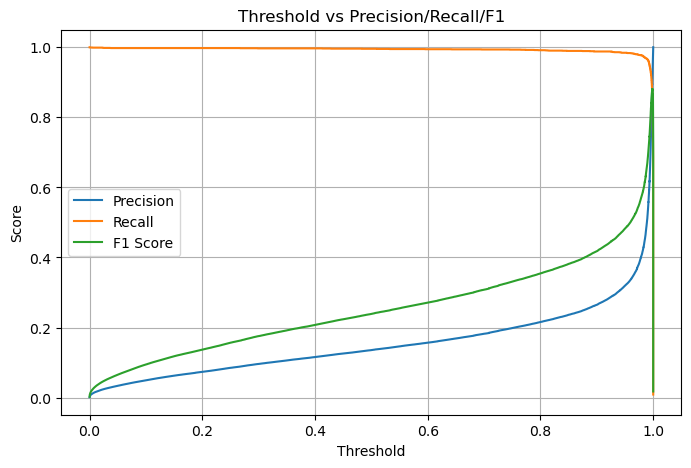

In [69]:
# Plot Precision, Recall, F1 vs Threshold
plt.figure(figsize=(8,5))
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.plot(thresholds, f1_scores[:-1], label="F1 Score")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold vs Precision/Recall/F1")
plt.legend()
plt.grid(True)
plt.show()

In [70]:
# Pick best threshold (max F1 or based on business choice)

best_threshold = thresholds[np.argmax(f1_scores)]
print("Best Threshold (max F1):", best_threshold)

# selects the threshold value from thresholds that gives the highest F1 score 
# by using the index of the maximum value in f1_scores.

Best Threshold (max F1): 0.9985096


In [71]:
# Apply best threshold
y_pred_new = (y_proba >= best_threshold).astype(int)

# By default, classification models use a threshold of 0.5 to decide between classes, 
# This may not give the best balance between precision and recall. 
# By calculating the best threshold based on the F1-score, we adjust the cutoff so the model better handles the imbalance, 
# improving detection of fraud while controlling false alarms depending on the business objective.

In [72]:
# Evaluate with new threshold
print("Classification Report with tuned threshold:")
print(classification_report(y_test, y_pred_new))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_new))

# how well your model performs after tuning the threshold compared to the default 0.5.

Classification Report with tuned threshold:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.91      0.85      0.88      2464

    accuracy                           1.00   1908786
   macro avg       0.96      0.93      0.94   1908786
weighted avg       1.00      1.00      1.00   1908786

Confusion Matrix:
 [[1906115     207]
 [    362    2102]]


Interpretation

True Negatives (TN) = 1,906,115

Correctly predicted non-fraud transactions. ✅

False Positives (FP) = 207

Non-fraud transactions incorrectly flagged as fraud.

Very low → high precision.

False Negatives (FN) = 362

Fraud transactions missed by the model.

Some frauds are slipping through → affects recall.

True Positives (TP) = 2,102

Fraud transactions correctly detected. ✅


# Classification Report Analysis

Fraud (Class 1):

Precision = 0.91 → Out of all flagged frauds, 91% were correct.

Recall = 0.85 → Model caught 85% of actual frauds.

F1 = 0.88 → Balanced fraud detection performance.

Non-Fraud (Class 0):

Precision = ~1.00 → Almost no false alarms.

Recall = ~1.00 → Nearly all non-frauds detected correctly.

F1 = 1.00 → Perfect classification.

Overall Accuracy: ~100% (dominated by non-fraud cases, but still very strong on fraud detection).

Macro Average F1 = 0.94 → Balances both classes fairly.

Weighted Average F1 = 1.00 → Extremely high due to the large number of non-fraud cases.

# Step 6- Identify Key Predictive Factors (Feature Importance)
Understand which features drive predictions.

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importance from XGBoost
importances = xgb.feature_importances_
features = X.columns 

# After training, you want to understand which features the model relies on the most.
# it helps in:

# Interpretability (explaining model decisions),

# Feature selection (removing irrelevant features),

# Business insights (e.g., which transaction factors strongly influence fraud detection).

In [74]:
# Create a DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by="Importance", ascending=False)


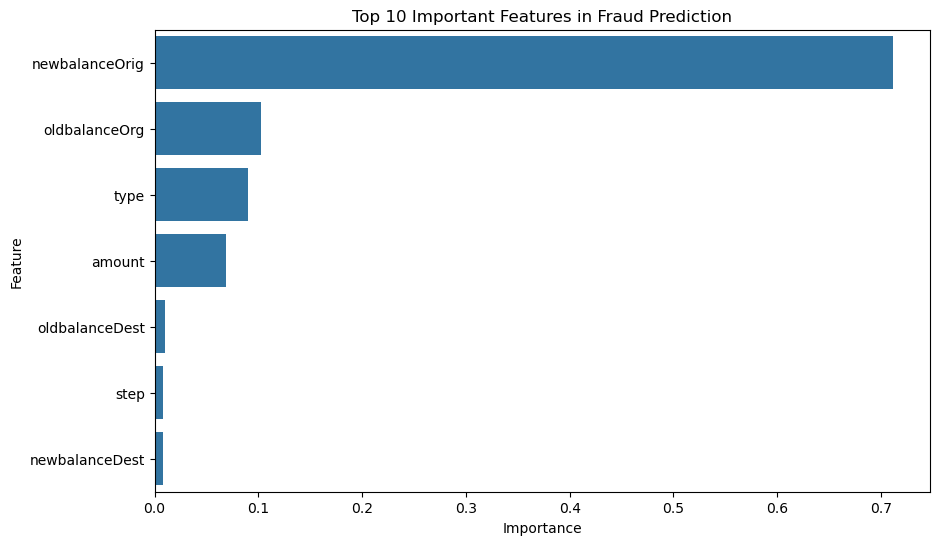

,Feature,Importance
4,newbalanceOrig,0.711346
3,oldbalanceOrg,0.102961
1,type,0.090435
2,amount,0.069133
5,oldbalanceDest,0.009965
0,step,0.008269
6,newbalanceDest,0.007891


In [75]:
# Plot
plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df.head(10))
plt.title("Top 10 Important Features in Fraud Prediction")
plt.show()

feature_importance_df.head(10)

# Check if Factors Make Sense

# Insights

Fraud mostly affects the sender’s balance: newbalanceOrig dominates.

Transaction type matters, but features like amount are less influential than balance changes.

Receiver balances and step are almost irrelevant, suggesting fraud is mainly detected by anomalies in sender’s balances.

This aligns with fraud logic: frauds often manipulate the sender’s account, not the receiver.

# Step 7- Fraud Prevention Strategies

In [70]:
# Example: Flag suspicious transactions based on business rules
def flag_suspicious(transaction):
    if transaction['type'] in ['TRANSFER', 'CASH_OUT'] and transaction['amount'] > 200000:
        return 1  # suspicious
    return 0

df3['suspicious_flag'] = df3.apply(flag_suspicious, axis=1)
df3['suspicious_flag'].value_counts()

suspicious_flag
0    5164951
1    1197669
Name: count, dtype: int64

# Step 8- Measuring Effectiveness

To measure impact, you need evaluation metrics over time. You can simulate by comparing fraud detected under normal threshold vs. tuned threshold.

In [77]:
from sklearn.metrics import confusion_matrix, classification_report

# Compare results between default threshold and tuned threshold
y_pred_default = (y_proba >= 0.5).astype(int)
y_pred_tuned   = (y_proba >= best_threshold).astype(int)

print("Default Threshold Report (0.5):")
print(classification_report(y_test, y_pred_default))

print("Tuned Threshold Report:")
print(classification_report(y_test, y_pred_tuned))

# Confusion matrices
print("Default Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_default))

print("Tuned Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_tuned))


Default Threshold Report (0.5):
              precision    recall  f1-score   support

           0       1.00      0.99      1.00   1906322
           1       0.14      1.00      0.24      2464

    accuracy                           0.99   1908786
   macro avg       0.57      0.99      0.62   1908786
weighted avg       1.00      0.99      0.99   1908786

Tuned Threshold Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.91      0.85      0.88      2464

    accuracy                           1.00   1908786
   macro avg       0.96      0.93      0.94   1908786
weighted avg       1.00      1.00      1.00   1908786

Default Confusion Matrix:
[[1890709   15613]
 [     11    2453]]
Tuned Confusion Matrix:
[[1906115     207]
 [    362    2102]]
